# Cross-contour transport plot

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import scipy.stats as ss
from collections import OrderedDict
from matplotlib import gridspec

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
from correlation import Compute_Correlation

import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44341,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.121.35:40031,Total threads: 4
Dashboard: /proxy/36977/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40071,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load important parameters

In [4]:
year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)


In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 3.85 s, sys: 1.38 s, total: 5.24 s
Wall time: 25.7 s


In [7]:
%%time

dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)


CPU times: user 894 ms, sys: 68.7 ms, total: 963 ms
Wall time: 10.7 s


In [8]:
ht = cc.querying.getvar(expt,'ht', session,n=1)
ht = ht.sel(yt_ocean = slice(-90,-34.99))

In [9]:
def find_arrow_dxn(lon,lat):
    N = 20

    smooth_lon = uniform_filter1d(lon, size=N)
    smooth_lat = uniform_filter1d(lat, size=N)
    
    smooth_lat_i = np.roll(smooth_lat,1)
    smooth_lon_i = np.roll(smooth_lon,1)
    
    Dy = smooth_lat_i-smooth_lat
    Dx = smooth_lon_i-smooth_lon
    
    dx = Dy/np.sqrt(Dy**2+Dx**2)
    dy = -Dx/np.sqrt(Dy**2+Dx**2)
    return dx, dy

In [10]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

# arrow plot

In [11]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 13})


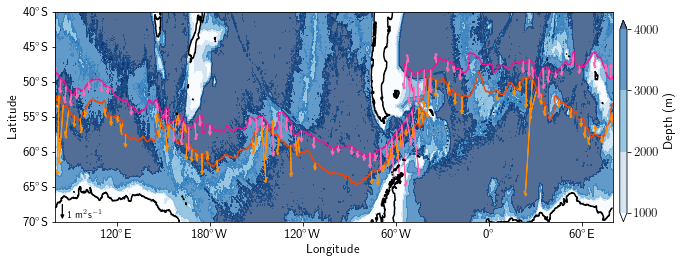

In [12]:
rhoslice = slice(1032.2,1032.5)
fig = plt.figure(figsize = (10,4))
p1 = ht.plot.contourf(levels = [1000,2000,3000,4000], cmap = 'Blues', alpha = 0.7, add_colorbar = False)

for j in np.arange(29):
    j_contour = ['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'][j]
    SSH = contour_dict[j_contour]['SSH']
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
        prefix = 400
    else:
        suffix = ''
        prefix = 0
    if j_contour == 'L':
        vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
        isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
        lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
        lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
        segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length
        bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
        top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff.sel(hotspot = 'total')
        # mask out water that touches surface or bottom on average
        SSH = contour_dict[j_contour]['SSH']
#         if SSH > -0.45:
#             print('SSH too big!!')
#         rhoslice = slice(top_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0],bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0])
#         print(rhoslice)

        N=10

        eddy_notcumsum = (vh_eddy.sel(isopycnal_bins=rhoslice).sum('isopycnal_bins')/segment_length).fillna(0)
        y = uniform_filter1d(eddy_notcumsum, size=N)

        dx, dy = find_arrow_dxn(lon_along_contour,lat_along_contour)
        for i in np.arange(10,len(lon_along_contour),50):
            if np.abs(y[i]) >0.2:

                plt.arrow(lon_along_contour[i],lat_along_contour[i],y[i]*dx[i]*2,y[i]*dy[i]*2,head_length = 0.5,head_width = 2,length_includes_head=False, color = 'darkorange')#,transform=ccrs.PlateCarree())#, head_length = 0.1,length_includes_head=True)

    #sc = ax.scatter(lon_along_contour,lat_along_contour, s=0.1, alpha = 0.4, label = 'SSH '+str(SSH)+' m', c = -y , cmap = cm.cm.ice_r, vmin = -100, vmax = 40000,transform=ccrs.PlateCarree())
        sc = plt.scatter(lon_along_contour,lat_along_contour, s=0.1, alpha = 0.5, color = 'orangered')
    if j_contour == 'H':
        vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
        lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
        lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour

        N=10
        bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
        top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff.sel(hotspot = 'total')
        # mask out water that touches surface or bottom on average
        SSH = contour_dict[j_contour]['SSH']
#         if SSH > -0.45:
#             print('SSH too big!!')
#         rhoslice = slice(top_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0],bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0])
#         print(rhoslice)
        segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length

        N=10

        eddy_notcumsum = (vh_eddy.sel(isopycnal_bins=rhoslice).sum('isopycnal_bins')/segment_length).fillna(0)
        y = uniform_filter1d(eddy_notcumsum, size=N)

        dx, dy = find_arrow_dxn(lon_along_contour,lat_along_contour)
        for i in np.arange(10,len(lon_along_contour),50):
            if np.abs(y[i]) >0.2:
                plt.arrow(lon_along_contour[i],lat_along_contour[i],y[i]*dx[i]*2,y[i]*dy[i]*2,head_length = 0.5,head_width = 2,length_includes_head=False, color = 'hotpink')#,transform=ccrs.PlateCarree())#, head_length = 0.1,length_includes_head=True)

    #sc = ax.scatter(lon_along_contour,lat_along_contour, s=0.1, alpha = 0.4, label = 'SSH '+str(SSH)+' m', c = -y , cmap = cm.cm.ice_r, vmin = -100, vmax = 40000,transform=ccrs.PlateCarree())
        sc = plt.scatter(lon_along_contour,lat_along_contour, s=0.1, alpha = 0.5, color = 'deeppink')
# ax_cb = plt.axes([0.95, 0.35, 0.01, 0.3])
# cb = plt.colorbar(sc,cax=ax_cb, orientation='vertical')
# cb.ax.set_ylabel('Southward eddy transport (m$^2$s$^{-1}$)', fontsize = 18);
# cb.ax.tick_params(labelsize=14)
plt.arrow(-275,-67.5,0,-2,head_length = 0.5,head_width = 2,length_includes_head=True, color = 'k')
plt.text(-272,-69.5,'1 m$^2$s$^{-1}$', color = 'k', fontsize = 10)
mask = (ht*0+1).fillna(0)
mask.plot.contour(levels = [0.5],colors = 'k')

X = np.arange(-240,100,60)
plt.xticks(X, ('120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
Y = np.arange(-70,-35,5)
plt.yticks(Y, ('70$^\circ$S','65$^\circ$S','60$^\circ$S','55$^\circ$S','50$^\circ$S','45$^\circ$S','40$^\circ$S'));
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.ylim(-70,-40)
plt.xlim(-280,80)
fig.subplots_adjust(bottom = 0.15, right = 0.9)

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
plt.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Depth (m)')
